# LABORATORIUM 5 - Procesy Gaussowskie

Importy:

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
import numpy as np
import tensorflow_probability as tfp
from tqdm import tqdm
from itertools import islice
import bokeh
import bokeh.io
import bokeh.plotting
import bokeh.models
from IPython.display import display, HTML
from datetime import datetime as dt
import time

In [3]:
tfb = tfp.bijectors
tfd = tfp.distributions
tfk = tfp.math.psd_kernels
bokeh.io.output_notebook(hide_banner=True)

## Przewidywanie koncentracji CO2 w długim horyzoncie czasowym

### Zadanie 1

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/UM/monthly_in_situ_co2_mlo.csv", skiprows=56)
df

,,,Excel,,[ppm],[ppm],[ppm],[ppm],[ppm],[ppm].1
0,1958,1,21200,1958.0411,-99.99,-99.99,-99.99,-99.99,-99.99,-99.99
1,1958,2,21231,1958.1260,-99.99,-99.99,-99.99,-99.99,-99.99,-99.99
2,1958,3,21259,1958.2027,315.70,314.43,316.20,314.91,315.70,314.43
3,1958,4,21290,1958.2877,317.45,315.16,317.30,314.99,317.45,315.16
4,1958,5,21320,1958.3699,317.51,314.71,317.87,315.07,317.51,314.71
...,...,...,...,...,...,...,...,...,...,...
775,2022,8,44788,2022.6219,-99.99,-99.99,-99.99,-99.99,-99.99,-99.99
776,2022,9,44819,2022.7068,-99.99,-99.99,-99.99,-99.99,-99.99,-99.99
777,2022,10,44849,2022.7890,-99.99,-99.99,-99.99,-99.99,-99.99,-99.99
778,2022,11,44880,2022.8740,-99.99,-99.99,-99.99,-99.99,-99.99,-99.99


In [ ]:
df_co2 = df[df.columns[3:5]]

In [ ]:
df_co2 = df_co2.rename(columns={df_co2.columns[0]: "date", df_co2.columns[1]: "co2"})
df_co2

,date,co2
0,1958.0411,-99.99
1,1958.1260,-99.99
2,1958.2027,315.70
3,1958.2877,317.45
4,1958.3699,317.51
...,...,...
775,2022.6219,-99.99
776,2022.7068,-99.99
777,2022.7890,-99.99
778,2022.8740,-99.99


### Zadanie 3

In [ ]:
df_co2 = df_co2.dropna()
df_co2 = df_co2[df_co2['co2'] >= 0.0]

In [ ]:
df_grouped = df_co2.groupby(df_co2['date'].map(lambda x: int(x))).mean()['co2']

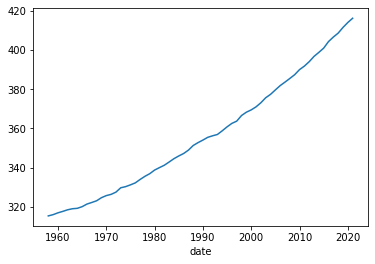

In [ ]:
df_grouped.plot()

Powyżej przedstawiono wykres średniej kroczącej dla każdego kolejnego roku.

### Zadanie 4

In [ ]:
df_train = df_co2[df_co2['date'] < 2012]
df_test = df_co2[df_co2['date'] >= 2012]

### Zadanie 5

In [ ]:
observations_mean = tf.constant([np.mean(df_train.co2.values)], dtype=tf.float64)
mean_fn = lambda _: observations_mean

### Zadanie 6

In [19]:
constrain_positive = tfb.Shift(np.finfo(np.float64).tiny)(tfb.Exp())

smooth_amplitude = tfp.util.TransformedVariable(
    initial_value=10., bijector=constrain_positive, dtype=np.float64,
    name='smooth_amplitude')
smooth_length_scale = tfp.util.TransformedVariable(
    initial_value=10., bijector=constrain_positive, dtype=np.float64,
    name='smooth_length_scale')

smooth_kernel = tfk.ExponentiatedQuadratic(
    amplitude=smooth_amplitude, 
    length_scale=smooth_length_scale)

periodic_amplitude = tfp.util.TransformedVariable(
    initial_value=5.0, bijector=constrain_positive, dtype=np.float64,
    name='periodic_amplitude')
periodic_length_scale = tfp.util.TransformedVariable(
    initial_value=1.0, bijector=constrain_positive, dtype=np.float64,
    name='periodic_length_scale')
periodic_period = tfp.util.TransformedVariable(
    initial_value=1.0, bijector=constrain_positive, dtype=np.float64,
    name='periodic_period')
periodic_local_length_scale = tfp.util.TransformedVariable(
    initial_value=1.0, bijector=constrain_positive, dtype=np.float64,
    name='periodic_local_length_scale')

local_periodic_kernel = (
    tfk.ExpSinSquared(
        amplitude=periodic_amplitude, 
        length_scale=periodic_length_scale,
        period=periodic_period) * 
    tfk.ExponentiatedQuadratic(
        length_scale=periodic_local_length_scale))

irregular_amplitude = tfp.util.TransformedVariable(
    initial_value=1., bijector=constrain_positive, dtype=np.float64,
    name='irregular_amplitude')
irregular_length_scale = tfp.util.TransformedVariable(
    initial_value=1., bijector=constrain_positive, dtype=np.float64,
    name='irregular_length_scale')
irregular_scale_mixture = tfp.util.TransformedVariable(
    initial_value=1., bijector=constrain_positive, dtype=np.float64,
    name='irregular_scale_mixture')

irregular_kernel = tfk.RationalQuadratic(
    amplitude=irregular_amplitude,
    length_scale=irregular_length_scale,
    scale_mixture_rate=irregular_scale_mixture)

observation_noise_variance = tfp.util.TransformedVariable(
    initial_value=1, bijector=constrain_positive, dtype=np.float64,
    name='observation_noise_variance')

trainable_variables = [v.variables[0] for v in [
    smooth_amplitude,
    smooth_length_scale,
    periodic_amplitude,
    periodic_length_scale,
    periodic_period,
    periodic_local_length_scale,
    irregular_amplitude,
    irregular_length_scale,
    irregular_scale_mixture,
    observation_noise_variance
]]

In [20]:
kernel = (smooth_kernel + local_periodic_kernel + irregular_kernel)

### Zadanie 7

In [ ]:
@tf.function(autograph=False, experimental_compile=False)
def gp_loss_fn(index_points, observations):
    """Gaussian process negative-log-likelihood loss function."""
    gp = tfd.GaussianProcess(
        mean_fn=mean_fn,
        kernel=kernel,
        index_points=index_points,
        observation_noise_variance=observation_noise_variance
    )
    
    negative_log_likelihood = -gp.log_prob(observations)
    return negative_log_likelihood

### Zadanie 8

In [ ]:
batch_size = 128

batched_dataset = (
    tf.data.Dataset.from_tensor_slices(
        (df_train.date.values.reshape(-1, 1), df_train.co2.values))
    .shuffle(buffer_size=len(df_train))
    .repeat(count=None)
    .batch(batch_size)
)

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

batch_nlls = [] 
full_ll = [] 
nb_iterations = 10001
for i, (index_points_batch, observations_batch) in tqdm(
        enumerate(islice(batched_dataset, nb_iterations)), total=nb_iterations):
    with tf.GradientTape() as tape:
        loss = gp_loss_fn(index_points_batch, observations_batch)
    grads = tape.gradient(loss, trainable_variables)
    optimizer.apply_gradients(zip(grads, trainable_variables))
    batch_nlls.append((i, loss.numpy()))
    if i % 100 == 0:
        ll = gp_loss_fn(
            index_points=df_train.date.values.reshape(-1, 1),
            observations=df_train.co2.values)
        full_ll.append((i, ll.numpy()))

100%|██████████| 10001/10001 [03:12<00:00, 52.03it/s]


### Zadanie 9

In [ ]:
fig = bokeh.plotting.figure(
    width=600, height=350, 
    x_range=(0, nb_iterations), y_range=(50, 200))
fig.add_layout(bokeh.models.Title(
    text='Negative Log-Likelihood (NLL) during training', 
    text_font_size="14pt"), 'above')
fig.xaxis.axis_label = 'iteration'
fig.yaxis.axis_label = 'NLL batch'

fig.line(
    *zip(*batch_nlls), legend_label='Batch data',
    line_width=2, line_color='midnightblue')

fig.extra_y_ranges = {
    'fig1ax2': bokeh.models.Range1d(start=130, end=250)}
fig.line(
    *zip(*full_ll), legend_label='All observed data',
    line_width=2, line_color='red', y_range_name='fig1ax2')
fig.add_layout(bokeh.models.LinearAxis(
    y_range_name='fig1ax2', axis_label='NLL all'), 'right')

fig.legend.location = 'top_right'
fig.toolbar.autohide = True
bokeh.plotting.show(fig)

### Zadanie 10

In [24]:
variables = [
    smooth_amplitude,
    smooth_length_scale,
    periodic_amplitude,
    periodic_length_scale,
    periodic_period,
    periodic_local_length_scale,
    irregular_amplitude,
    irregular_length_scale,
    irregular_scale_mixture,
    observation_noise_variance
]

data = list([(var.variables[0].name[:-2], var.numpy()) for var in variables])
df_variables = pd.DataFrame(
    data, columns=['Hyperparameters', 'Value'])
display(HTML(df_variables.to_html(
    index=False, float_format=lambda x: f'{x:.4f}')))

Hyperparameters,Value
smooth_amplitude,1497.9365345724423
smooth_length_scale,0.07634435510201061
periodic_amplitude,41.9569652575722
periodic_length_scale,0.1815545064101442
periodic_period,0.37808232763029626
periodic_local_length_scale,0.4258865893757777
irregular_amplitude,2.089962879629691
irregular_length_scale,0.5884487033833156
irregular_scale_mixture,1.658762404656631
observation_noise_variance,2.438774838443981


### Zadanie 11

In [ ]:
gp_posterior_predict = tfd.GaussianProcessRegressionModel(
    mean_fn=mean_fn,
    kernel=kernel,
    index_points=df_test.date.values.reshape(-1, 1),
    observation_index_points=df_train.date.values.reshape(-1, 1),
    observations=df_train.co2.values,
    observation_noise_variance=observation_noise_variance)

posterior_mean_predict = gp_posterior_predict.mean()
posterior_std_predict = gp_posterior_predict.stddev()

### Zadanie 12

In [ ]:
μ = posterior_mean_predict.numpy()
σ = posterior_std_predict.numpy()

fig = bokeh.plotting.figure(
    width=600, height=400,
    x_range=(2010, 2021.3), y_range=(384, 418))
fig.xaxis.axis_label = 'Date'
fig.yaxis.axis_label = 'CO₂ (ppm)'
fig.add_layout(bokeh.models.Title(
    text='Posterior predictions conditioned on observations before 2010.',
    text_font_style="italic"), 'above')
fig.add_layout(bokeh.models.Title(
    text='Atmospheric CO₂ concentrations', 
    text_font_size="14pt"), 'above')
fig.circle(
    df_co2.date, df_co2.co2, legend_label='True data',
    size=2, line_color='midnightblue')
fig.line(
    df_test.date.values, μ, legend_label='μ (predictions)',
    line_width=2, line_color='firebrick')

band_x = np.append(
    df_test.date.values, df_test.date.values[::-1])
band_y = np.append(
    (μ + 2*σ), (μ - 2*σ)[::-1])
fig.patch(
    band_x, band_y, color='firebrick', alpha=0.4, 
    line_color='firebrick', legend_label='2σ')

fig.legend.location = 'top_left'
fig.toolbar.autohide = True
bokeh.plotting.show(fig)

### Zadanie 13

Wyniki przewidywania mieszczą się w przedziale +-2σ od 2010 do 2016 roku. Od 2016 roku widać, że rzeczywiste wartości są znacznie wyższe niż predykcje modelu.

## Przewidywanie notowań giełdowych w horyzoncie 7 i 14 dni

### Wig20

In [4]:
def toYearFraction(date):
    def sinceEpoch(date): 
        return time.mktime(date.timetuple())
    s = sinceEpoch

    year = date.year
    startOfThisYear = dt(year=year, month=1, day=1)
    startOfNextYear = dt(year=year+1, month=1, day=1)

    yearElapsed = s(date) - s(startOfThisYear)
    yearDuration = s(startOfNextYear) - s(startOfThisYear)
    fraction = yearElapsed/yearDuration

    return date.year + fraction

In [5]:
def toYearFrac(date):
  year, month, day = list(map(int, date.split("-")))
  dateTime = dt(year, month, day)
  return toYearFraction(dateTime)

In [6]:
toYearFrac("2022-01-29")

2022.0767123287671

In [7]:
wig = pd.read_csv("/content/drive/MyDrive/UM/wig20_d.csv")
wig = wig.dropna()
wig = wig[wig.Wolumen >= 0.0]
wig

,Data,Otwarcie,Najwyzszy,Najnizszy,Zamkniecie,Wolumen
0,1991-04-16,100.00,100.00,100.00,100.00,325
1,1991-04-23,95.70,95.70,95.70,95.70,5905
2,1991-04-30,93.50,93.50,93.50,93.50,7162
3,1991-05-14,92.90,92.90,92.90,92.90,18300
4,1991-05-21,95.50,95.50,95.50,95.50,14750
...,...,...,...,...,...,...
6963,2020-12-04,1894.40,1952.28,1894.35,1947.68,28408098
6964,2020-12-07,1949.61,1965.92,1926.87,1958.53,32118759
6965,2020-12-08,1941.14,1970.27,1933.68,1970.27,33485126
6966,2020-12-09,1976.65,2023.91,1976.65,1994.12,57962389


In [8]:
wig_train_2019 = wig[wig["Data"] < "2019"]
wig_test_2019 = wig[wig["Data"] > "2019"]
wig_train_2020 = wig[wig["Data"] < "2020"]
wig_test_2020 = wig[wig["Data"] > "2020"]

In [9]:
assert len(wig) == len(wig_train_2019) + len(wig_test_2019)
assert len(wig) == len(wig_train_2020) + len(wig_test_2020)

In [10]:
observations_mean = tf.constant([np.mean(wig_train_2019.Wolumen.values)], dtype=tf.float64)
mean_fn = lambda _: observations_mean

In [11]:
@tf.function(autograph=False, experimental_compile=False)
def gp_loss_fn(index_points, observations):
    """Gaussian process negative-log-likelihood loss function."""
    gp = tfd.GaussianProcess(
        mean_fn=mean_fn,
        kernel=kernel,
        index_points=index_points,
        observation_noise_variance=observation_noise_variance
    )
    
    negative_log_likelihood = -gp.log_prob(observations)
    return negative_log_likelihood

In [12]:
date_train_2019 = wig_train_2019.Data.map(toYearFrac).values.reshape(-1, 1)
max_wol = wig_train_2019.Wolumen.max()
wolumen_train_2019 = wig_train_2019.Wolumen.map(lambda x: float(x)/max_wol).values

In [13]:
date_train_2020 = wig_train_2020.Data.map(toYearFrac).values.reshape(-1, 1)
max_wol = wig_train_2020.Wolumen.max()
wolumen_train_2020 = wig_train_2020.Wolumen.map(lambda x: float(x)/max_wol).values

In [14]:
test_2019_7 = wig_test_2019.Data.map(toYearFrac).values[:7]
test_2019_14 = wig_test_2019.Data.map(toYearFrac).values[:14]

In [15]:
test_2019_7_values = wig_test_2019.Wolumen.map(float).values[:7]
test_2019_14_values = wig_test_2019.Wolumen.map(float).values[:14]

In [16]:
wolumen_train_2019

array([1.26295360e-06, 2.29468954e-05, 2.78316113e-05, ...,
       2.71542703e-01, 6.13206602e-02, 6.66055926e-02])

In [17]:
batch_size = 128

batched_dataset = (
    tf.data.Dataset.from_tensor_slices(
        (date_train_2019, wolumen_train_2019))
    .shuffle(buffer_size=len(wig_train_2019))
    .repeat(count=None)
    .batch(batch_size)
)

In [21]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

batch_nlls = [] 
full_ll = [] 
nb_iterations = 10001
for i, (index_points_batch, observations_batch) in tqdm(
        enumerate(islice(batched_dataset, nb_iterations)), total=nb_iterations):
    with tf.GradientTape() as tape:
        loss = gp_loss_fn(index_points_batch, observations_batch)
    grads = tape.gradient(loss, trainable_variables)
    optimizer.apply_gradients(zip(grads, trainable_variables))
    batch_nlls.append((i, loss.numpy()))
    if i % 100 == 0:
        ll = gp_loss_fn(
            index_points=date_train_2019,
            observations=wolumen_train_2019)
        full_ll.append((i, ll.numpy()))

100%|██████████| 10001/10001 [02:57<00:00, 56.30it/s]


In [22]:
min_y = min(list(map(lambda x: x[1], full_ll)))
max_y = max(list(map(lambda x: x[1], full_ll)))
fig = bokeh.plotting.figure(
    width=600, height=350, 
    x_range=(0, nb_iterations), y_range=(0, max_y))
fig.add_layout(bokeh.models.Title(
    text='Negative Log-Likelihood during training (Wig20 2019)', 
    text_font_size="14pt"), 'above')
fig.xaxis.axis_label = 'iteration'
fig.yaxis.axis_label = 'NLL batch'

fig.line(
    *zip(*batch_nlls), legend_label='Batch data',
    line_width=2, line_color='midnightblue')

fig.extra_y_ranges = {
    'fig1ax2': bokeh.models.Range1d(start=0, end=max_y)}
fig.line(
    *zip(*full_ll), legend_label='All observed data',
    line_width=2, line_color='red', y_range_name='fig1ax2')
fig.add_layout(bokeh.models.LinearAxis(
    y_range_name='fig1ax2', axis_label='NLL all'), 'right')

fig.legend.location = 'top_right'
fig.toolbar.autohide = True
bokeh.plotting.show(fig)

In [23]:
def plot_posterior(title, years_split, dates, values, samples):
  batch_nlls = {}
  full_ll = {}
  for year_split in years_split:
    train_dates = np.array(list(filter(lambda x: x < year_split, dates)))
    train_values = np.array(values[:len(train_dates)])

    observations_mean = tf.constant([np.mean(train_values)], dtype=tf.float64)
    mean_fn = lambda _: observations_mean

    kernel = (smooth_kernel + local_periodic_kernel + irregular_kernel)

    @tf.function(autograph=False, experimental_compile=False)
    def gp_loss_fn(index_points, observations):
        """Gaussian process negative-log-likelihood loss function."""
        gp = tfd.GaussianProcess(
            mean_fn=mean_fn,
            kernel=kernel,
            index_points=index_points,
            observation_noise_variance=observation_noise_variance
        )
        
        negative_log_likelihood = -gp.log_prob(observations)
        return negative_log_likelihood

    batch_size = 128

    batched_dataset = (
        tf.data.Dataset.from_tensor_slices(
            (train_dates.reshape(-1, 1), train_values))
        .shuffle(buffer_size=len(train_values))
        .repeat(count=None)
        .batch(batch_size)
    )

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

    batch_nlls[year_split] = [] 
    full_ll[year_split] = [] 
    nb_iterations = 10001
    for i, (index_points_batch, observations_batch) in tqdm(
            enumerate(islice(batched_dataset, nb_iterations)), total=nb_iterations):
        with tf.GradientTape() as tape:
            loss = gp_loss_fn(index_points_batch, observations_batch)
        grads = tape.gradient(loss, trainable_variables)
        optimizer.apply_gradients(zip(grads, trainable_variables))
        batch_nlls[year_split].append((i, loss.numpy()))
        if i % 100 == 0:
          ll = gp_loss_fn(
              index_points=train_dates.reshape(-1, 1),
              observations=train_values)
          full_ll[year_split].append((i, ll.numpy()))

    for sample in samples:
      test_dates = np.array(list(filter(lambda x: x >= year_split, dates))[:sample])

      gp_posterior_predict = tfd.GaussianProcessRegressionModel(
        mean_fn=mean_fn,
        kernel=kernel,
        index_points=test_dates.reshape(-1, 1),
        observation_index_points=train_dates.reshape(-1, 1),
        observations=train_values,
        observation_noise_variance=observation_noise_variance)

      posterior_mean_predict = gp_posterior_predict.mean()
      posterior_std_predict = gp_posterior_predict.stddev()

      μ = posterior_mean_predict.numpy()
      σ = posterior_std_predict.numpy()

      fig = bokeh.plotting.figure(
          width=600, height=400,
          x_range=(test_dates[0], test_dates[-1]), y_range=(0, 0.2))
      fig.xaxis.axis_label = 'Date'
      fig.yaxis.axis_label = 'Value'
      fig.add_layout(bokeh.models.Title(
          text=f'Posterior predictions conditioned on observations before {year_split}.',
          text_font_style="italic"), 'above')
      fig.add_layout(bokeh.models.Title(
          text=title, 
          text_font_size="14pt"), 'above')
      fig.circle(
          dates, values, legend_label='True data',
          size=2, line_color='midnightblue')
      fig.line(
          test_dates[:sample], μ, legend_label='μ (predictions)',
          line_width=2, line_color='firebrick')

      band_x = np.append(
          test_dates[:sample], test_dates[:sample][::-1])
      band_y = np.append(
          (μ + 2*σ), (μ - 2*σ)[::-1])

      fig.patch(
          band_x, band_y, color='firebrick', alpha=0.4, 
          line_color='firebrick', legend_label='2σ')

      fig.legend.location = 'top_left'
      fig.toolbar.autohide = True
      bokeh.plotting.show(fig)

  return [batch_nlls, full_ll]

Poniżej przedstawiono wyniki dla danych WIG20 (ustandaryzowanych) kolejno:
  -   podział: 2019, predykcja na 7 pierwszych dni z 2019
  -   podział: 2019, predykcja na 14 pierwszych dni z 2019
  -   podział: 2020, predykcja na 7 pierwszych dni z 2020
  -   podział: 2020, predykcja na 14 pierwszych dni z 2020

In [24]:
wig_dates = wig.Data.map(toYearFrac).values
wig_max = wig.Wolumen.max()
wig_values = wig.Wolumen.map(lambda x: float(x)/wig_max).values
plot_posterior("WIG20", [2019, 2020], wig_dates, wig_values, [7, 14])

100%|██████████| 10001/10001 [02:44<00:00, 60.81it/s]


100%|██████████| 10001/10001 [02:53<00:00, 57.75it/s]


[{2019: [(0, 438.06658118319535),
   (1, 423.6946068507489),
   (2, 432.14854613588733),
   (3, 425.84699050039774),
   (4, 434.84731694002767),
   (5, 432.83376032702233),
   (6, 433.87675189683256),
   (7, 435.6379638951055),
   (8, 424.8701467744684),
   (9, 431.287950202509),
   (10, 427.1534845078895),
   (11, 431.2868911592426),
   (12, 429.85787729473077),
   (13, 424.8612783533523),
   (14, 424.7330662824618),
   (15, 430.32758505091647),
   (16, 424.2078329162909),
   (17, 418.334285311162),
   (18, 421.643103705452),
   (19, 424.39270174254034),
   (20, 428.0725668816723),
   (21, 425.48961614011523),
   (22, 421.75746285057795),
   (23, 423.0459413327898),
   (24, 422.5104076530048),
   (25, 425.14776611732714),
   (26, 418.5919707862497),
   (27, 420.9233476514018),
   (28, 426.1523031926811),
   (29, 418.78656347064936),
   (30, 426.4301184835149),
   (31, 424.1278886447271),
   (32, 424.1646003597259),
   (33, 427.77126423896175),
   (34, 428.76602136916375),
   (35, 416.



Poniżej przedstawiono wyniki dla danych WIG20 (nieustandaryzowanych) kolejno:
  -  podział: 2019, predykcja na 7 pierwszych dni z 2019
  -  podział: 2019, predykcja na 14 pierwszych dni z 2019
  -  podział: 2020, predykcja na 7 pierwszych dni z 2020
  -  podział: 2020, predykcja na 14 pierwszych dni z 2020



In [ ]:
wig_dates = wig.Data.map(toYearFrac).values
wig_values = wig.Wolumen.map(float).values
plot_posterior("WIG20", [2019, 2020], wig_dates, wig_values, [7, 14])

Lepsze predykcje osiągnęliśmy dla podziału w roku 2020. Jeśli chodzi o przedziały ufności dużo lepiej to wyszło dla danych ustandaryzowanych.

### Comarch

Analogicznie jak powyżej

In [26]:
comarch = pd.read_csv("/content/drive/MyDrive/UM/cmr_d.csv")
comarch = comarch.dropna()
comarch = comarch[comarch.Wolumen >= 0.0]
comarch

,Data,Otwarcie,Najwyzszy,Najnizszy,Zamkniecie,Wolumen
0,1999-03-10,21.756,21.756,21.756,21.756,205957
1,1999-03-11,23.766,23.766,23.766,23.766,104554
2,1999-03-12,26.053,26.053,26.053,26.053,98970
3,1999-03-15,28.612,28.612,28.612,28.612,69065
4,1999-03-16,28.612,28.612,28.612,28.612,162327
...,...,...,...,...,...,...
5440,2020-12-07,198.000,198.000,193.500,196.000,633
5441,2020-12-08,196.000,196.000,193.500,195.000,374
5442,2020-12-09,196.000,198.000,196.000,197.500,1906
5443,2020-12-10,196.500,197.500,193.000,193.500,459


In [27]:
comarch_dates = comarch.Data.map(toYearFrac).values
comarch_max = comarch.Wolumen.max()
comarch_values = comarch.Wolumen.map(lambda x: float(x)/comarch_max).values
res_stand = plot_posterior("Comarch", [2019, 2020], comarch_dates, comarch_values, [7, 14])

100%|██████████| 10001/10001 [02:14<00:00, 74.52it/s]


100%|██████████| 10001/10001 [02:21<00:00, 70.47it/s]


In [28]:
comarch = comarch.dropna()
comarch = comarch[comarch.Wolumen >= 0.0]
comarch_dates = comarch.Data.map(toYearFrac).values
comarch_values = comarch.Wolumen.map(float).values
res_normal = plot_posterior("Comarch", [2019, 2020], comarch_dates, comarch_values, [7, 14])

100%|██████████| 10001/10001 [02:14<00:00, 74.16it/s]


100%|██████████| 10001/10001 [02:19<00:00, 71.50it/s]


Dla danych Comarchu uzyskano całkiem sensowne wyniki - wykres odzwierciedla monotoniczność predykowanych wartości, ponadto udało się też kilka z nich poprawnie zpredykować.